In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pywt # Esta libreria es la que maneja las transformadas
import pywt.data
from scipy import signal
from scipy.ndimage import gaussian_filter
from matplotlib.image import imread

In [2]:
# Cargar imagen y simular desenfoque
# original = img.imread('imagen.jpg')
original = pywt.data.camera()

In [3]:
from scipy.signal.windows import gaussian
from scipy.signal import convolve2d

size = 35
sigma = 7
gk1d = gaussian(size, std=sigma).reshape(size, 1)
blur_kernel = gk1d @ gk1d.T
blur_kernel = blur_kernel / np.sum(blur_kernel)

In [4]:
# # Simular desenfoque con un kernel gaussiano
# kernel_size = 15
# sigma = 3
# blur_kernel = np.zeros((kernel_size, kernel_size))
# for i in range(kernel_size):
#     for j in range(kernel_size):
#         dist = np.sqrt((i - kernel_size//2)**2 + (j - kernel_size//2)**2)
#         blur_kernel[i, j] = np.exp(-dist**2 / (2*sigma**2))
# blur_kernel = blur_kernel / np.sum(blur_kernel)

In [5]:
# @title Blurred imaged aplyying convolved and kernel filter
blurred = signal.convolve2d(original, blur_kernel, mode='same')

In [6]:
# Función de soft thresholding para los coeficientes wavelet
def soft_threshold(x, threshold):
    return np.sign(x) * np.maximum(np.abs(x) - threshold, 0)

In [13]:
def admm_wavelet_deblur(blurred_img, kernel, wavelet='bior1.3', lambda_param=0.0001,  rho=5, iterations=300):
    # 1. Transformada wavelet, con la libreria
    coeffs = pywt.dwt2(blurred_img, wavelet)
    LL, (LH, HL, HH) = coeffs

    # Preparar el kernel en el dominio de frecuencia, estos dominios son aquellos
    # donde se aplica cada transformada, eso fue lo que entendi en un paper.
    kernel_fft = np.fft.fft2(kernel, s=blurred_img.shape)
    kernel_conj_fft = np.conjugate(kernel_fft)

    # Variables ADMM, para correr la función, también son nuestras varibles objetivo
    x = blurred_img.copy()
    z = x.copy()
    u = np.zeros_like(x)

    for _ in range(iterations):
        # x-update (minimiza ||Hx - y||^2 + rho/2||x - z + u||^2)
        x_plus_u_fft = np.fft.fft2(z - u)
        numerator = kernel_conj_fft * np.fft.fft2(blurred_img) + rho * x_plus_u_fft
        denominator = np.abs(kernel_fft)**2 + rho
        x = np.real(np.fft.ifft2(numerator / denominator))

        # z-update con soft thresholding en dominio wavelet
        x_plus_u = x + u
        coeffs_x = pywt.dwt2(x_plus_u, wavelet)
        LL_x, (LH_x, HL_x, HH_x) = coeffs_x

        # Aplicar soft thresholding solo a los detalles
        LH_z = soft_threshold(LH_x, lambda_param/rho)
        HL_z = soft_threshold(HL_x, lambda_param/rho)
        HH_z = soft_threshold(HH_x, lambda_param/rho)

        # Reconstruir con coeficientes procesados
        z = pywt.idwt2((LL_x, (LH_z, HL_z, HH_z)), wavelet)

        # u-update
        u = u + (x - z)

    return z

In [14]:

# Ejecutar pipeline completo
# 1. Aplicar ADMM con soft thresholding en dominio wavelet
deblurred_admm = admm_wavelet_deblur(blurred, blur_kernel, lambda_param=0.002783)

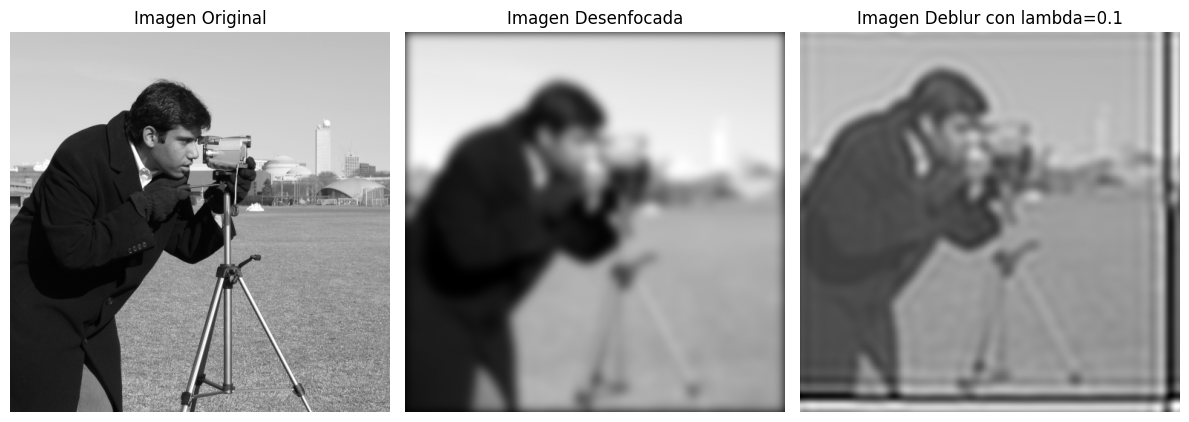

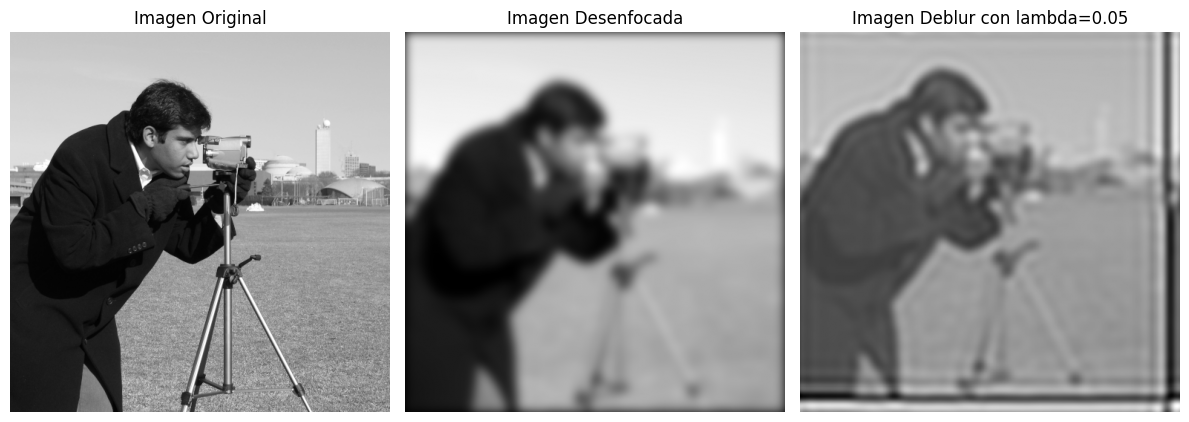

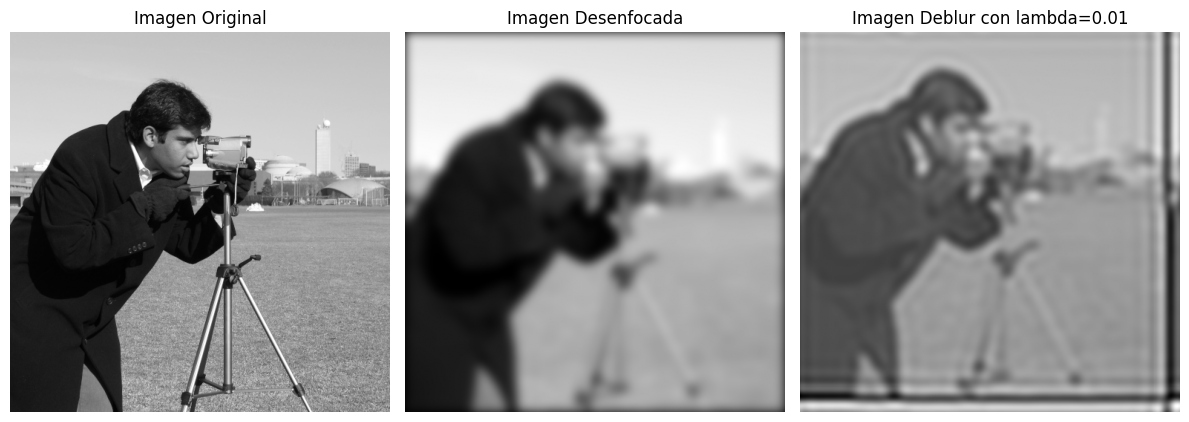

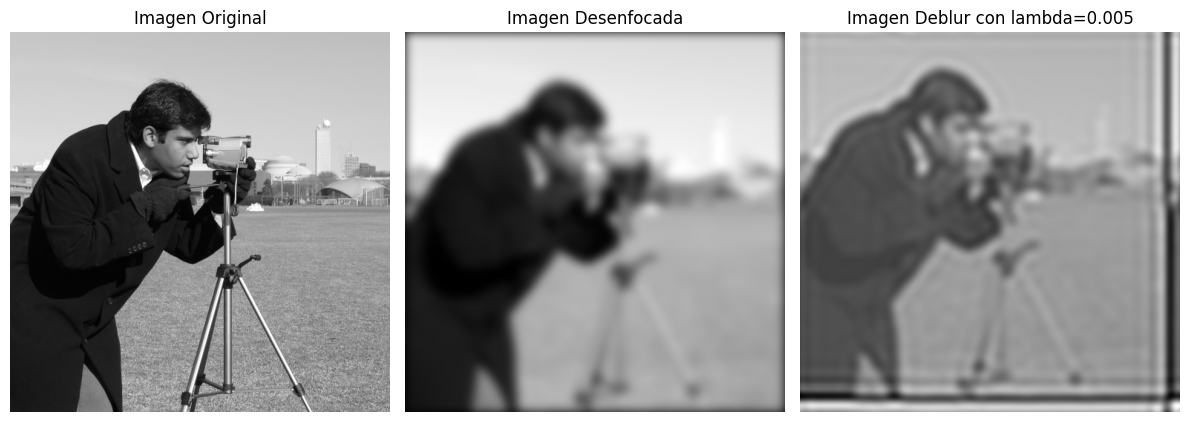

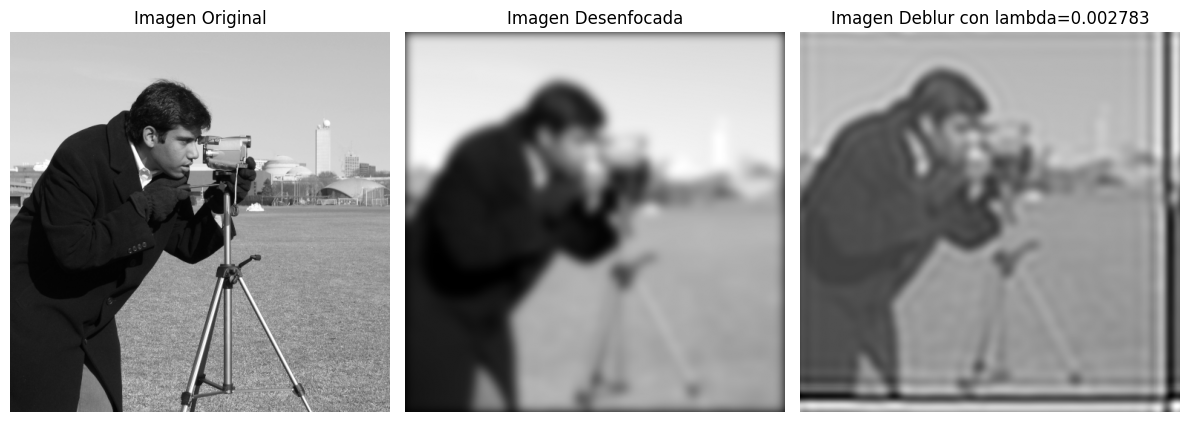

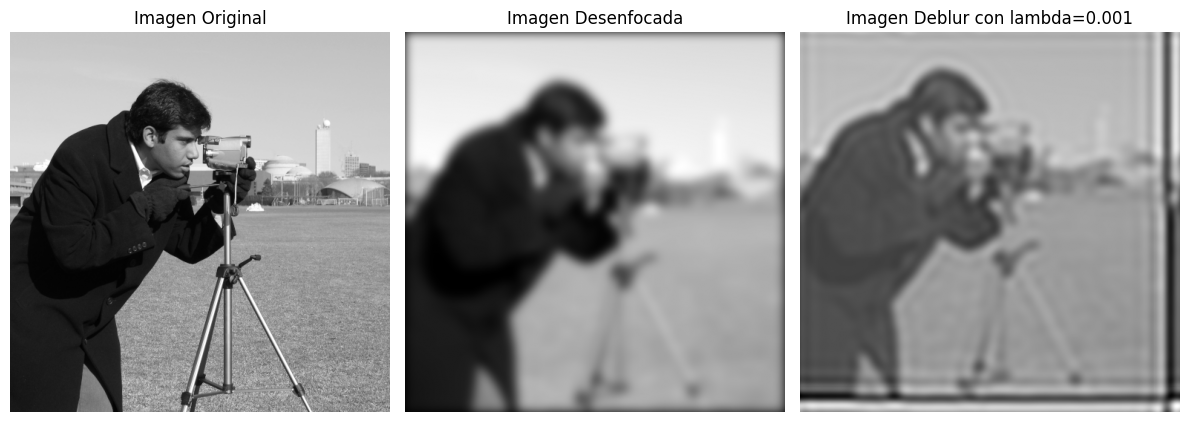

In [15]:
# Probar diferentes valores de lambda_param
lambda_values = [0.001,0.002783, 0.005, 0.01, 0.05, 0.1]
sorted_lambda_values = sorted(lambda_values, reverse=True)
for lambda_val in sorted_lambda_values:
    deblurred_admm = admm_wavelet_deblur(blurred, blur_kernel, lambda_param=lambda_val, rho=5, iterations=300)
    # 2. Mostrar resultados
    plt.figure(figsize=(12, 8))
    plt.subplot(1, 3, 1)
    plt.title('Imagen Original')
    plt.imshow(original, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Imagen Desenfocada')
    plt.imshow(blurred, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title(f'Imagen Deblur con lambda={lambda_val}')
    plt.imshow(deblurred_admm, cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [16]:
#psnr
def psnr(original, deblurred):
    mse = np.mean((original - deblurred) ** 2)
    if mse == 0:
        return float('inf')  # No error
    max_pixel = 255.0 if original.dtype == np.uint8 else 1.0
    return 20 * np.log10(max_pixel / np.sqrt(mse))

In [ ]:

# Calculate PSNR for each lambda value  
lambda_values = np.logspace(-1, -3, 15)  # 15 points logarithmically spaced from 10^-1 to 10^-3
psnr_values = []

for lambda_val in lambda_values:
    deblurred_admm = admm_wavelet_deblur(blurred, blur_kernel, lambda_param=lambda_val)
    psnr_value = psnr(original, deblurred_admm)
    psnr_values.append(psnr_value)
    print(f'PSNR para lambda={lambda_val:.6f}: {psnr_value:.2f} dB')

# Plot PSNR vs lambda with smooth curve
plt.figure(figsize=(10, 6))
plt.plot(lambda_values, psnr_values, marker='o', linestyle='-', linewidth=2, markersize=5)
plt.title('PSNR vs Lambda (Smoothed)', fontsize=14)
plt.xlabel('Lambda', fontsize=12)
plt.ylabel('PSNR (dB)', fontsize=12)
plt.xscale('log')
plt.grid(True)
# Add minor grid lines
plt.gca().xaxis.grid(True, which='minor', linestyle='--', alpha=0.4)
# Reverse x-axis to show values from 10^-1 to 10^-3
plt.gca().invert_xaxis()
plt.tight_layout()
plt.show()

PSNR para lambda=0.100000: 12.98 dB
PSNR para lambda=0.071969: 12.99 dB
PSNR para lambda=0.051795: 12.99 dB
PSNR para lambda=0.037276: 12.99 dB
PSNR para lambda=0.026827: 12.99 dB
PSNR para lambda=0.019307: 12.99 dB


PSNR% para iteración 1: 20.03 dB
PSNR% para iteración 2: 19.56 dB
PSNR% para iteración 3: 18.98 dB
PSNR% para iteración 4: 18.40 dB
PSNR% para iteración 5: 17.86 dB
PSNR% para iteración 6: 17.39 dB
PSNR% para iteración 7: 16.97 dB
PSNR% para iteración 8: 16.61 dB
PSNR% para iteración 9: 16.30 dB
PSNR% para iteración 10: 16.03 dB
PSNR% para iteración 11: 15.80 dB
PSNR% para iteración 12: 15.59 dB
PSNR% para iteración 13: 15.41 dB
PSNR% para iteración 14: 15.26 dB
PSNR% para iteración 15: 15.12 dB
PSNR% para iteración 16: 15.00 dB
PSNR% para iteración 17: 14.89 dB
PSNR% para iteración 18: 14.79 dB
PSNR% para iteración 19: 14.71 dB
PSNR% para iteración 20: 14.63 dB


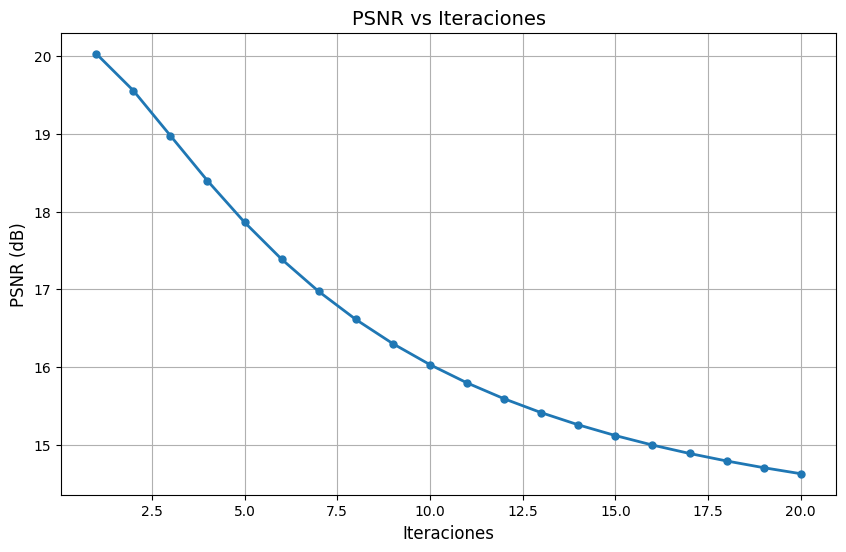

In [ ]:
#psnr vs iterations
def psnr_vs_iterations(original, blurred, kernel, wavelet='bior1.3', lambda_param=0.002, rho=5.0, max_iterations=20):
    psnr_values = []
    for iteration in range(1, max_iterations + 1):
        deblurred = admm_wavelet_deblur(blurred, kernel, wavelet=wavelet, lambda_param=lambda_param, rho=rho, iterations=iteration)
        psnr_value = psnr(original, deblurred)
        psnr_values.append(psnr_value)
        print(f'PSNR% para iteración {iteration}: {psnr_value:.2f} dB')
    return psnr_values
# Calcular PSNR vs Iteraciones  
psnr_iterations = psnr_vs_iterations(original, blurred, blur_kernel, lambda_param=0.002, rho=5.0, max_iterations=20)
# Graficar PSNR vs Iteraciones
plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), psnr_iterations, marker='o', linestyle='-', linewidth=2, markersize=5)
plt.title('PSNR vs Iteraciones', fontsize=14)
plt.xlabel('Iteraciones', fontsize=12)
plt.ylabel('PSNR (dB)', fontsize=12)
plt.grid(True)